![banner](../static/banner.png)

---

# Part 4 - Creating neural networks to classify handwritten digits 🔢✍🏾

## WORK IN PROGRESS
**TODO:**
- Consider placing helper functions in separate file, and source them into this file to reduce clutter.
- Finish writing outline/"plan of attack", including:
    - A more fleshed out explanation of the problem at hand (including information about the MNIST data set, plot some examples)
    - What kind of network we are going to create (number of layers, number of nodes per layer, and a brief explanation of why)
    - Describe (or ask participants) to brainstorm/think about what kind of components we might need to actually get this to work in code.
- Make it more interactive (put in place "exercises" of "challenges" for participants to do themselves, rather than having everything done for them).
- Import neuralnet package to do this automatically
- Update visualise digit function so it can plot multiple + training and test

## Classifying handwritten digits
Consider the following sequence of handwritten digits.

![handwritten-digits](http://neuralnetworksanddeeplearning.com/images/digits.png)

Many of us learn to how to read such numerals at a young age, and can effortlessly recognize those digits as 504192. But how could we go about getting a computer to recognise these digits?

We could try programming in some of our intuitions and heuristics for recognising digits, such as "a 9 has a loop at the top and a vertical stroke in the bottom right". 

## The MNIST database 🧮

The [MNIST database](https://en.wikipedia.org/wiki/MNIST_database) is a large database of handwritten digits.

## Plan of attack 🎯

https://www.cs.ryerson.ca/~aharley/vis/fc/

- Describe how we're going to use NN to solve the above problem
- E.g. what kind of neural network we're going to use, how many layers, how many hidden nodes etc.
- Conceptual overview of the data and the network so that people don't dive into the code without any understanding of what we're actually doing
- Outline key steps:
    - Prepare our environment (load in required packages)
    - Load in the data and convert it into required format (training and test, transpose etc)
    - Define some simple but useful functions (activation functions, helper functions e.g. shuffle, dot product, one hot encoding etc) (**NOTE**: Participants don't need to understand these, not important)
    - Initialise neural net
    - Feed forward
    - Backpropagation
    - Gradient descent
    - Measuring accuracy and plotting results

## Let's code it up 👩‍💻

### Preparing our coding environment

Theres a couple of packages we'll use in this example. `data.table` gives us a function to read large `csv` files super quickly, and `ggplot2` allows us to create some nice graphics.

In [1]:
library(data.table) # To read the csv file quickly
library(ggplot2) # For basic plotting
set.seed(1)

### Helper functions

These functions are used to help make coding and visualising our neural net a little bit easier. **You don't need to understand these** to get the what our neural network is doing, but feel free to take a look if you're curious!

In [2]:
shuffle = function(A) {
  # Shuffles the rows of a matrix
  return(A[sample(nrow(A)), ])
}

one_hot = function(Y) {
  # Converts Y from a list of numbers (categorical variables) to a matrix.
  # In this matrix, each column corresponds to a digit. In each column, all
  # entries are zero except there is a single 1. The row that this 1 is in
  # encodes what number the digit encoded in that column is.
  # For example, a 1 in column 78, row 6 of the matrix would mean that the 78th 
  # digit in Y is a 5 (since row numbers start from 1, but our lowest digit is 0).
  one_hot_Y = matrix(0, length(Y), max(Y) + 1)
  for(i in 1:length(Y)) {
    one_hot_Y[i, Y[i] + 1] = 1
  }
  one_hot_Y = t(one_hot_Y)
  return(one_hot_Y)
}

print_training_progress = function(nn, Y, iteration) {
    # Prints to console some information as the network is being trained
    cat("-*-")
    flush.console()

    if (iteration %% 10 == 0) {
      cat("\n")
      predictions = get_predictions(nn)
      accuracy = get_accuracy(predictions, Y)
      cat(paste0("Iteration: ", iteration, ", Accuracy: ", round(accuracy, 2), "\n"))
      flush.console()
    }
}

plot_activation = function(activation_function, x = seq(-7,7,0.001)) {
    # Used to plot the activation function
    df = data.frame(x = x, y = activation_function(x))
    options(repr.plot.width = 12, repr.plot.height = 5)
    
    ggplot(df, aes(x, y)) +
      geom_line(lwd = 1.5) +
      theme_minimal() +
      theme(text = element_text(size = 20), element_line(size = 1)) +
      ylab(paste0("y = ", deparse(substitute(activation_function)), "(x)"))
}

display_digit = function(X, digit_index, label = TRUE) {
    # Plots a visual representation of a digit.
    digit = matrix(X[, digit_index], nrow = 28, ncol = 28)
    digit = digit[, nrow(digit):1]     # The image function is annoying, it flips matrices upside down, this fixes it.
    image(1:28, 1:28, digit, col = gray((255:0)/255.), axes = FALSE, xlab = "", ylab = "")
    box(col = "black") 
    if(label) {
        title(paste0("Digit label: ", as.character(Y_train[digit_index])), col.main = "black", line = 0.7, cex.main = 2)
    }
}

### Loading in the MNIST data

The code below is used to read in the MNIST handwritten data. Don't worry about this too much for now. The basic gist of it is that we load in a data from a `.csv` file, convert it to a matrix, and then split it into a training and test set. 

In [3]:
data = data.table::fread("../data/kaggle-MNIST-train.csv")
data = as.matrix(data)
m = nrow(data)
n = ncol(data)

data = shuffle(data)

data_test = t(data[1:1000, ])
Y_test = data_test[1, ]
X_test = data_test[2:n, ]
X_test = X_test / 255.

data_train = t(data[1001:m, ])
Y_train = data_train[1, ]
X_train = data_train[2:n, ]
X_train = X_train / 255.

Here's what our data looks like when visualised. Change the example number to see a bunch of different examples included in our data. 

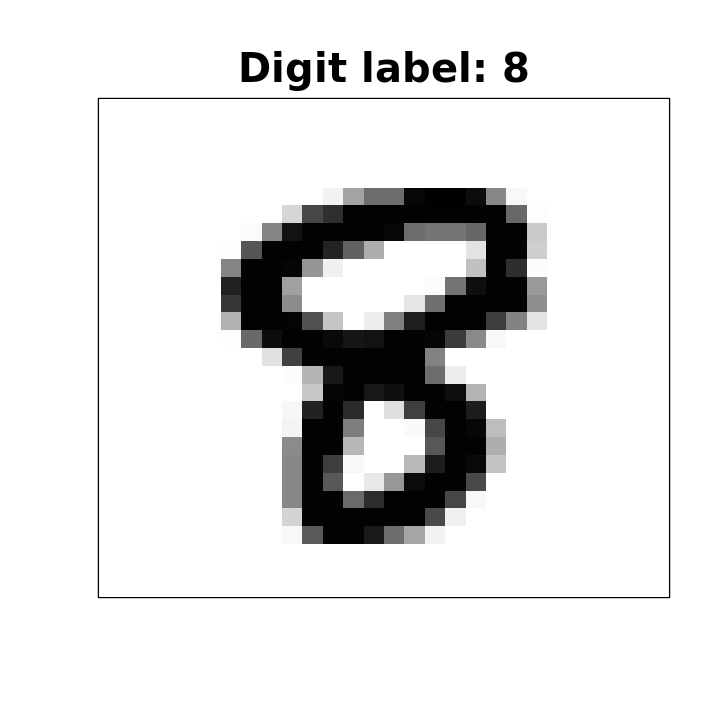

In [20]:
options(repr.plot.width = 6, repr.plot.height = 6)

example_number = 2512
display_digit(X_train, example_number, label = TRUE)

### Coding the Neural Network

#### Activation functions
Here we define the activation function we'll use in our network (and it's derivative). The function we'll use for our network is a classic, called the ***sigmoid function***.

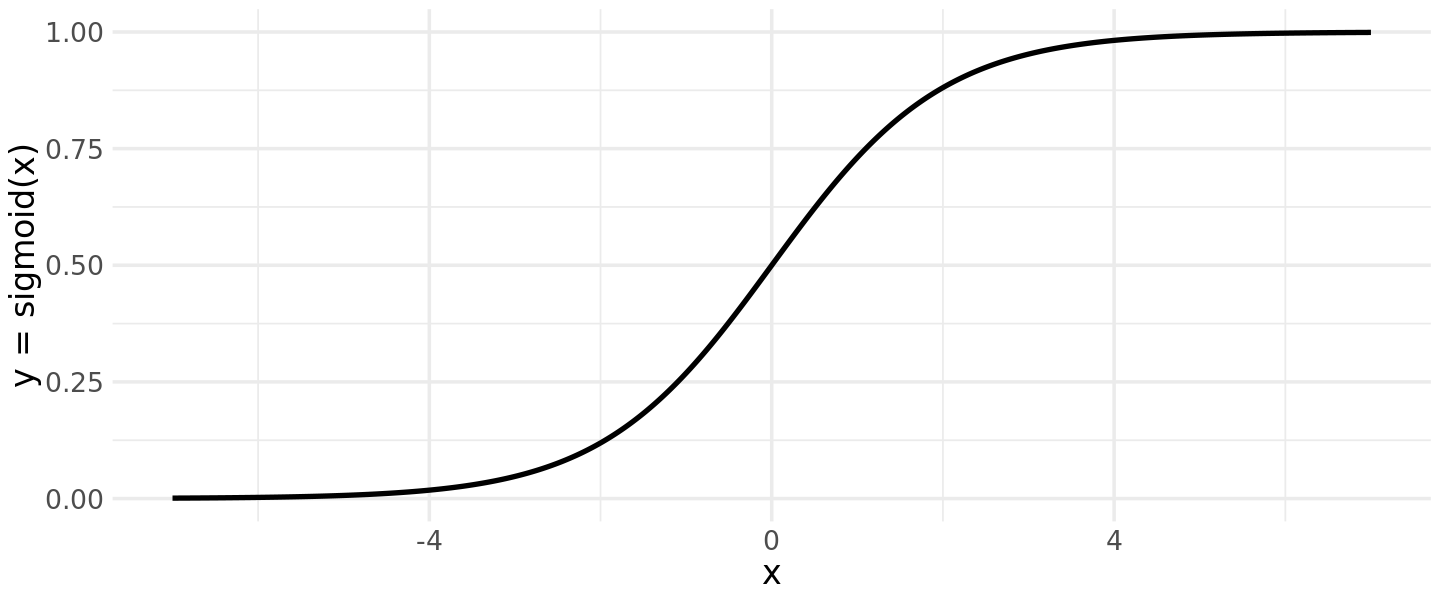

In [5]:
sigmoid = function(Z) {
  # The sigmoid function.
  return(1/(1 + exp(-Z)))
}

sigmoid_derivative = function(Z) {
  # The derivative of the sigmoid function.
  return(sigmoid(Z) * (1 - sigmoid(Z)))
}

plot_activation(sigmoid)

#### Initialising the neural network
In order to train our network to recognise digits, we first have to create it! The function below initialises our neural network with random weights and biases (sampled from a standard normal), and returns them as a list.

As described above, we focus on creating a simple network with one hidden layer.

**Your task:** How many neurons should we have in our input layer? How about in our output layer? Replace the `???` in the function below.

In [6]:
initialise_net = function(num_hidden_nodes = 16) {
  # Initialises a neural network with one hidden layer.
  # Takes in an integer representing the number of nodes to be placed in the hidden layer.
  # Returns a list containing randomly initialised weights and biases.
    
  num_layers = 3 # One input layer, one hidden layer and one output layer for a total of three layers
  n_h = num_hidden_nodes # Change name for brevity
  
  n_input = 784
  n_output = 10

  nn = list(
    num_layers = num_layers,
    num_connections = num_layers - 1,
    W1 = matrix(data = rnorm(n_input * num_hidden_nodes), nrow = n_h, ncol = n_input),
    b1 = rnorm(n_h),
    W2 = matrix(data = rnorm(n_h * n_output), nrow = n_output, ncol = n_h),
    b2 = rnorm(n_output)
  ) 
  return(nn)
}

Run the cell below to initialise a neural network and view its contents!

In [7]:
initialise_net()

1.6612551,-1.89334201,-0.5672718,-2.240450037,0.176709610,-0.2262188,0.6243723,-2.28921387,1.41531641,0.6611880,⋯,-0.213424262,0.6191953,-0.02784289,0.91629833,0.03737269,0.4560429,-0.1858121,-1.6587283,-0.35799718,-0.55046004
-0.3685495,-0.30528770,-1.3667952,0.081484580,2.155427691,-1.4183957,-1.4572370,-0.90475986,0.74867601,-1.5087460,⋯,-0.856688566,-1.6342115,-1.15632401,-0.89714279,0.93136376,-1.2752326,-0.8533220,0.2979242,-0.38405708,1.02628158
0.1934677,1.21462035,0.6978957,-0.439206500,0.796259215,-0.3343718,1.7726620,-0.19335923,0.62965667,1.1246954,⋯,-0.774673621,0.4969118,1.28452147,-1.60739442,0.38746965,0.3988959,1.4272539,-1.2671047,-0.37819889,1.53435864
0.9578218,-0.62832864,-0.1372493,0.094073340,-0.783160256,0.5866468,0.4968944,-1.95231765,-0.43781361,-0.1804410,⋯,0.457217169,-0.2507800,0.52380787,0.69850264,0.17162180,0.5389278,0.6783848,0.1004032,0.44741217,-0.19301354
-0.3090370,-0.66522698,-1.0058360,0.269596228,0.369407827,1.8514914,-0.5431954,-1.38589152,0.20659561,1.2286248,⋯,-0.432492216,-1.2978990,-0.37125649,-0.16849396,0.03449293,0.5168703,-0.2321431,-0.9992441,0.97556354,-0.59516042
-1.2401617,-0.70287035,1.0488664,-0.023773187,-0.008557857,-0.4933550,-0.5174860,1.33610175,1.18228759,0.6027493,⋯,0.004930436,-0.1766202,-0.31327485,-0.08304253,0.07970466,-0.2572375,-0.1743767,-1.4040184,1.01669512,-0.46039738
1.2962796,1.49074679,-1.4597402,0.282750637,2.259284694,0.7498409,0.1783355,0.29648114,-0.01276586,-0.7096485,⋯,0.658816887,-1.9199932,0.82276851,-1.11566638,0.13656423,-1.1540377,-0.8494569,-1.8704554,0.68269438,0.82113383
-1.7399045,-0.94279588,-0.3390336,0.203591886,-0.333097074,1.4320718,-0.4982957,0.01441257,-0.38755196,0.6327092,⋯,-1.131384743,-1.3708991,-0.60144328,0.25163522,0.97769135,-0.7968538,2.2780664,0.7092423,0.55355549,0.88296280
-1.0023822,1.02185580,-0.5287513,-0.042601220,-0.102702211,-0.9003334,-0.2000624,-0.14597297,0.95693427,-1.2271720,⋯,-1.123915643,0.6506011,0.46976717,-0.29695483,1.05099603,-0.6976578,0.1052667,-0.4313903,2.99074440,-2.57054791
-1.5518588,-1.10230914,1.5339930,0.172130594,-0.346672658,-0.5871964,0.5798804,1.50858768,-1.23612108,2.2767922,⋯,-0.595597520,-0.6079915,1.04222355,1.12884571,0.21345902,-0.1148669,1.7676246,1.2494411,0.53216413,0.17169006
-1.3832193,-0.25953859,0.9085054,0.009454583,-1.055593023,1.5630901,-2.0960709,-1.13192751,-0.63050189,-0.7033589,⋯,-0.400385066,-0.1071758,-0.54150249,-0.69029356,-1.36596536,1.8603793,0.3629290,-0.5185813,-0.72864118,-0.29995511


#### Forward propagation
The process of passing information into the input layer and propagating it through the network is called forward propagation (or forward passing). The function below uses matrix arithmetic to pass through all our data at once. This function looks a little scary, and uses some matrix maths, but all its really doing is pushing all all the data in matrix `X` through the network in one neat line of code.

Note that here `%*%` is the operator we use for matrix multiplication.

**Your task**: There are two things missing from the forward propagation code below, identify whats missing and fix it.

In [8]:
forward_prop = function(nn, X) {
  nn$Z1 = (nn$W1 %*% X) + nn$b1
  nn$A1 = sigmoid(nn$Z1)
  nn$Z2 = (nn$W2 %*% nn$A1) + nn$b2
  nn$A2 = sigmoid(nn$Z2)
  return(nn)
}

#### Backpropagation
In order to train our network, we measure how well our network is performing, and adjust the weights and biases accordingly. This is where ***backpropagation*** comes in. Using the true values of the data, it pushes some measure of the difference from the output layer through the network from back to front, and by using some multivariable calculus and linear algebra, allows us to figure out how best to change our weights and biases to improve the accuracy of the network.

If you haven't done much linear algebra and calculus before (and even if you have) the math can be a bit tricky, so don't worry too much about exactly what's going on here. For now, the overarching idea is more important than the precise mathematics.

In [9]:
back_prop = function(nn, X, Y) {
  dZ2 = nn$A2 - one_hot(Y)
  nn$dW2 = 1 / m * dZ2 %*% t(nn$A1)
  nn$db2 = 1 / m * sum(dZ2)
  dZ1 = t(nn$W2) %*% dZ2 * sigmoid_derivative(nn$Z1)
  nn$dW1 = 1 / m * dZ1 %*% t(X)
  nn$db1 = 1 / m * sum(dZ1)
  return(nn)
}

#### Updating the network's parameters
Running backpropagation tells us whether we should increase or decrease our each of our weights and biases, and comparatively, how "important" changes are relative to eachother, but it doesn't actually change them, nor does it tell us by how much we should actually change them!

The update_params function allows us to use the information we got from running the backpropogation function to actually change our weights and biases. The rate at which these are changed is determined by what we call the ***learning rate***. Learning rate is an example of what is called a ***hyper-parameter***, a value that controls the "learning" process, and isn't set by training. 

**Your task**: Fill in the function body so that it updates all the parameters of our neural network.

*Hint:* Look at the values that the `back_prop` function adds to our network. What do they mean?

*Another hint:* You can do this in four lines of code, all of which will be pretty similar!

In [10]:
update_params = function(nn, learning_rate) {
  nn$W1 = nn$W1 - learning_rate * nn$dW1
  nn$b1 = nn$b1 - learning_rate * nn$db1    
  nn$W2 = nn$W2 - learning_rate * nn$dW2  
  nn$b2 = nn$b2 - learning_rate * nn$db2    
  return(nn)
}

#### Training the network - Gradient Descent

When we combine forward propagation, backpropagation and our parameter updates, we get what's known as the gradient descent algorithm.

![](https://camo.githubusercontent.com/8ea43a1f70612fe0be12346955ed5befd10c6bbdf2e850d04fe3bf865d25445d/68747470733a2f2f707669676965722e6769746875622e696f2f6d656469612f696d672f70617274312f6772616469656e745f64657363656e742e676966)

In [11]:
get_predictions = function(nn) {
  # - 1 to account for the fact that R indexes from 1 not 0
  predictions = apply(nn$A2, 2, which.max) - 1
  return(predictions)
}

get_accuracy = function(predictions, Y) {
  return(sum(predictions == Y)/length(Y))
}

gradient_descent = function(nn, X, Y, learning_rate, iterations) {
  for (i in 1:iterations) {
    nn = forward_prop(nn, X)
    nn = back_prop(nn, X, Y)
    nn = update_params(nn, learning_rate)
    print_training_progress(nn, Y, i)
  }
  return(nn)
}

If everything has gone right above, you should be able to run the cell below to train the network! (Warning: Each iteration takes between 1 - 2 seconds, so it may take a few minutes to finish training the network.)

In [12]:
nn = initialise_net(30)
nn = gradient_descent(nn, X_train, Y_train, learning_rate = 1, iterations = 200)

-*--*--*--*--*--*--*--*--*--*-
Iteration: 10, Accuracy: 0.28
-*--*--*--*--*--*--*--*--*--*-
Iteration: 20, Accuracy: 0.42
-*--*--*--*--*--*--*--*--*--*-
Iteration: 30, Accuracy: 0.51
-*--*--*--*--*--*--*--*--*--*-
Iteration: 40, Accuracy: 0.57
-*--*--*--*--*--*--*--*--*--*-
Iteration: 50, Accuracy: 0.61
-*--*--*--*--*--*--*--*--*--*-
Iteration: 60, Accuracy: 0.64
-*--*--*--*--*--*--*--*--*--*-
Iteration: 70, Accuracy: 0.67
-*--*--*--*--*--*--*--*--*--*-
Iteration: 80, Accuracy: 0.69
-*--*--*--*--*--*--*--*--*--*-
Iteration: 90, Accuracy: 0.71
-*--*--*--*--*--*--*--*--*--*-
Iteration: 100, Accuracy: 0.72
-*--*--*--*--*--*--*--*--*--*-
Iteration: 110, Accuracy: 0.74
-*--*--*--*--*--*--*--*--*--*-
Iteration: 120, Accuracy: 0.75
-*--*--*--*--*--*--*--*--*--*-
Iteration: 130, Accuracy: 0.76
-*--*--*--*--*--*--*--*--*--*-
Iteration: 140, Accuracy: 0.76
-*--*--*--*--*--*--*--*--*--*-
Iteration: 150, Accuracy: 0.77
-*--*--*--*--*--*--*--*--*--*-
Iteration: 160, Accuracy: 0.78
-*--*--*--*--*--*

#### Testing the network 

But how good is our network? Let's test it on some data it hasn't seen before!

In [13]:
nn = forward_prop(nn, X_test)
predictions = get_predictions(nn)
accuracy = get_accuracy(predictions, Y_test)

In [14]:
accuracy

[1] 0.797

In [15]:
which(predictions != Y_test)

[1]   1   2   4   8  20  37  42  43  49  65  67  69  70  71  78  85  90  93
 [19] 107 110 115 117 118 122 123 125 130 145 150 154 156 158 162 164 166 168
 [37] 169 170 177 185 186 196 197 202 204 206 209 214 215 216 229 230 231 233
 [55] 242 247 248 249 253 267 268 275 276 279 280 287 291 295 301 303 313 324
 [73] 327 329 337 349 350 365 372 377 382 384 392 398 400 402 407 414 433 434
 [91] 442 444 446 447 459 475 480 500 501 507 512 515 518 522 526 530 534 537
[109] 556 561 563 567 570 572 576 589 590 591 595 597 604 607 610 613 619 658
[127] 663 668 669 673 677 684 687 695 700 703 707 708 710 713 716 717 726 727
[145] 731 733 736 750 762 763 764 767 772 779 782 786 791 793 795 796 798 805
[163] 821 823 825 828 842 843 846 850 851 852 854 855 866 873 881 883 888 902
[181] 911 913 918 923 932 933 941 944 950 953 957 962 964 966 969 970 972 976
[199] 978 979 985 992 997

[1] 2

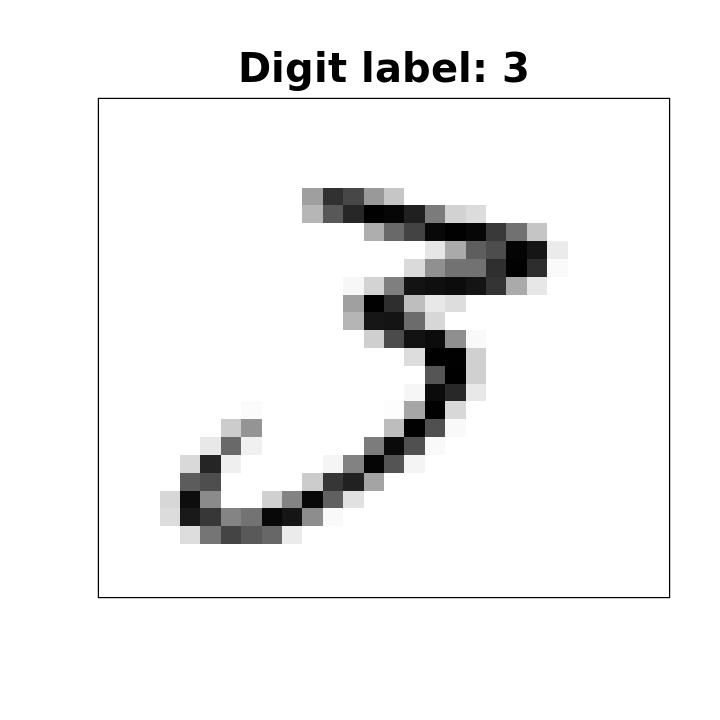

In [21]:
display_digit_test = function(X, digit_index, label = TRUE) {
    # Plots a visual representation of a digit.
    digit = matrix(X[, digit_index], nrow = 28, ncol = 28)
    digit = digit[, nrow(digit):1]     # The image function is annoying, it flips matrices upside down, this fixes it.
    image(1:28, 1:28, digit, col = gray((255:0)/255.), axes = FALSE, xlab = "", ylab = "")
    box(col = "black") 
    if(label) {
        title(paste0("Digit label: ", as.character(Y_test[digit_index])), col.main = "black", line = 0.7, cex.main = 2)
    }
}

example = 1
predictions[example]
display_digit_test(X_test, example)

[1] 9

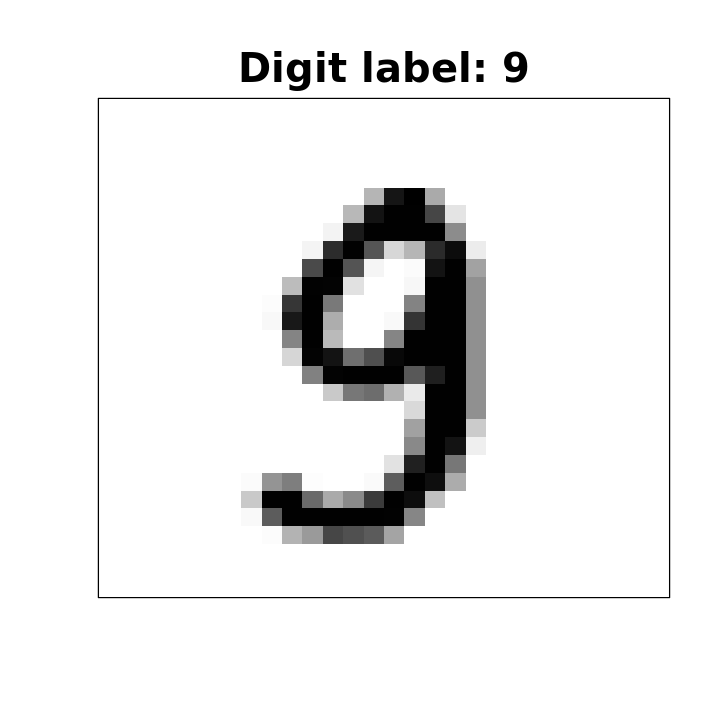

In [22]:
example = 33
predictions[example]
display_digit_test(X_test, example)

In [23]:
which(Y_test == 2)

[1]   5   9  17  19  29  32  37  49  85  94 101 111 123 138 140 141 150 166
 [19] 173 176 197 206 208 216 233 252 260 262 263 271 272 275 276 285 290 291
 [37] 295 310 311 312 326 336 341 344 347 348 362 365 378 389 390 393 402 410
 [55] 434 479 481 493 504 507 519 521 526 552 557 564 566 567 569 596 599 603
 [73] 606 614 627 646 656 660 674 680 683 688 705 729 731 736 780 792 797 813
 [91] 832 840 852 854 872 875 890 906 926 927 937 942 943 946 949 968 976 978
[109] 982 984 988 997

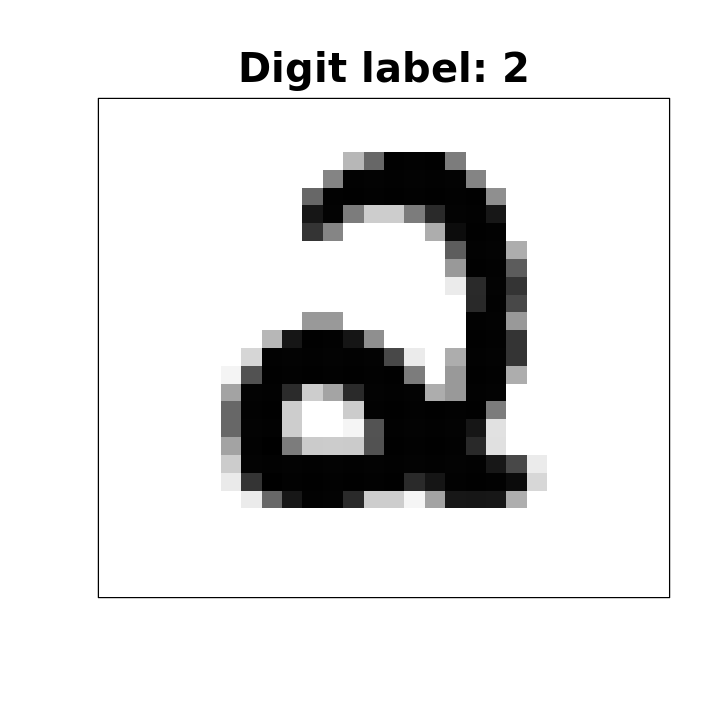

In [24]:
display_digit_test(X_test, 5)

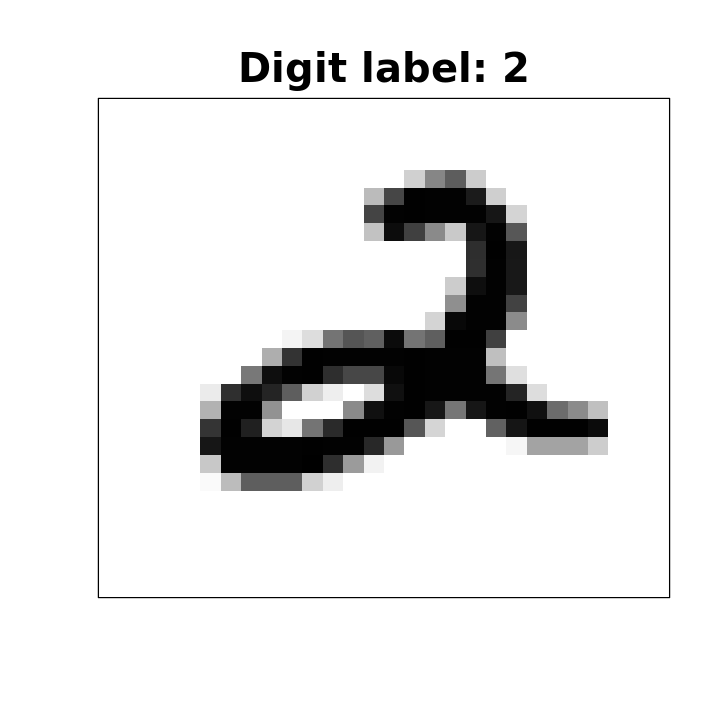

In [25]:
display_digit_test(X_test, 9)

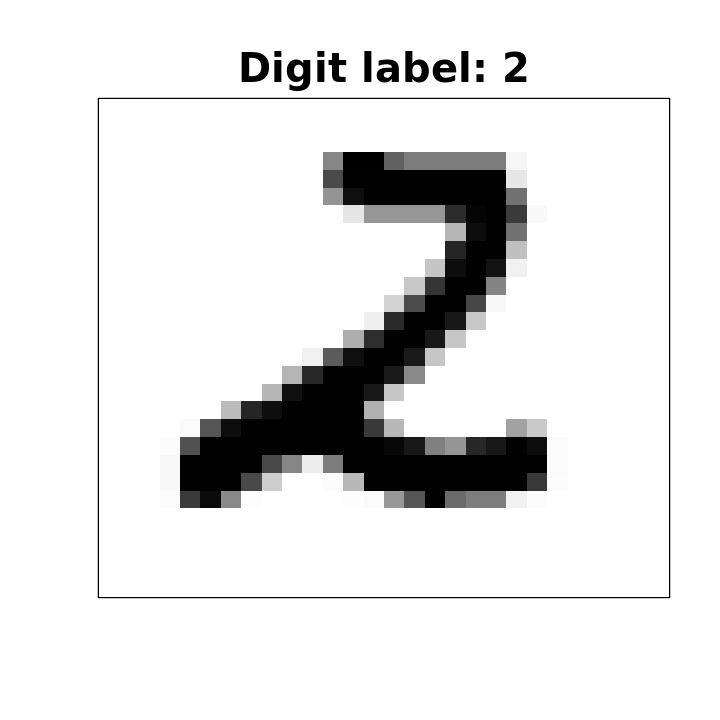

In [29]:
display_digit_test(X_test, 29)

---
## ↪️ Next up: [Part 5 🚀 - Discovering more](./5_Discovering_More.ipynb)